In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import statsmodels.api as sm
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Layer, LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.regularizers import l1,l2
from keras import regularizers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.layers import Layer,RNN
from keras import backend as K
from keras import layers
import keras.layers
from keras import *


In [ ]:
! pip install scikeras

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/datasets/coinbase.csv',index_col=[1])
df.head()

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931


In [ ]:
df.shape

(451681, 1)

In [4]:
use_features = ['USD']
target = 'USD'

In [5]:
df = df.fillna(method='backfill')

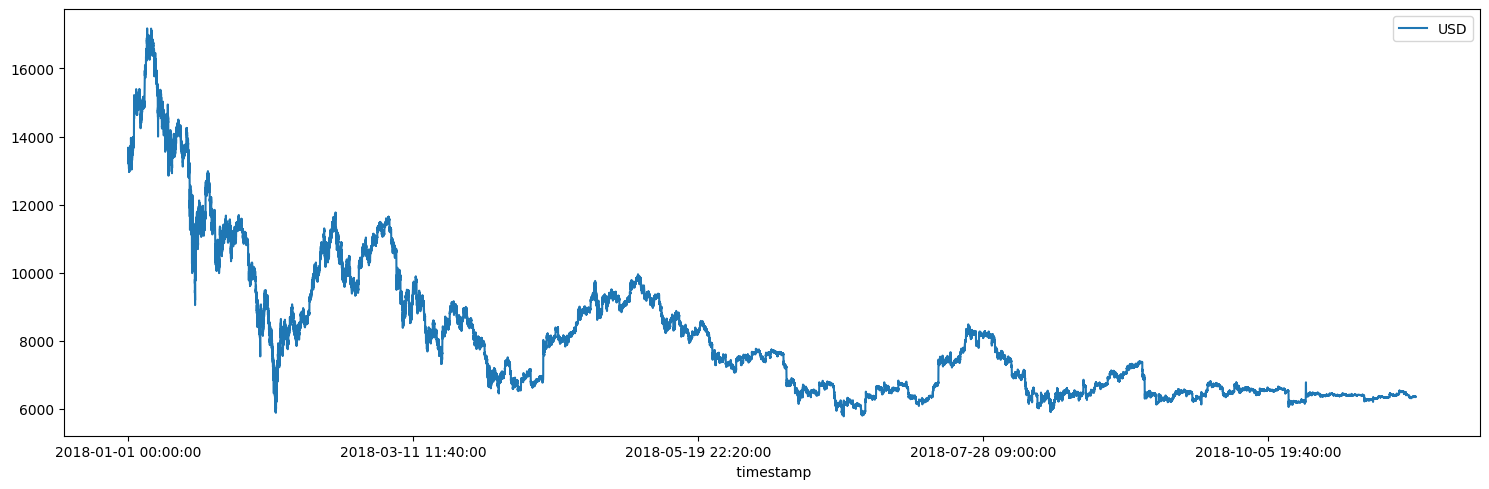

In [ ]:
df[use_features].plot(figsize=(15, 5))
plt.tight_layout()
plt.show()

In [ ]:
adf,p,usedlag,nobs,cvs,aic = sm.tsa.stattools.adfuller(df[use_features[0]][:200000].values)

In [ ]:
print(adf,p,nobs,cvs)

-2.094557163375779 0.24670881839394532 199918 {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


In [ ]:
pacf = sm.tsa.stattools.pacf(df[use_features],nlags=30)

In [ ]:
n_steps = np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df[use_features])))==False)[0][0] -1

In [ ]:
print(n_steps)

4


In [17]:
n_steps = 4

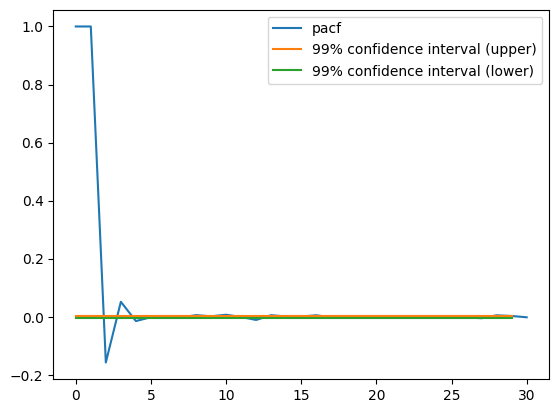

In [ ]:
plt.plot(pacf,label='pacf')
plt.plot([2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (lower)')
plt.legend()

In [6]:
train_per = 0.8
split = int(len(df)*train_per)
df_train = df.iloc[:split]

In [7]:
df_train

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931
...,...
2018-09-08 23:19:00,6189.563555
2018-09-08 23:20:00,6189.970822
2018-09-08 23:21:00,6189.998823


In [8]:
mu = float(df_train[use_features].mean())
sigma = float(df_train[use_features].std())

<ipython-input-8-ad3b73af5805>:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(df_train[use_features].mean())
<ipython-input-8-ad3b73af5805>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(df_train[use_features].std())


In [9]:
print(mu)
print(sigma)

8471.704544514587
2168.711409691284


In [10]:
df_train = df_train[use_features].apply(lambda x: (x-mu)/sigma)

In [11]:
df_train.shape

(361344, 1)

In [12]:
df_train

,USD
timestamp,
2018-01-01 00:00:00,2.364127
2018-01-01 00:01:00,2.363250
2018-01-01 00:02:00,2.350083
2018-01-01 00:03:00,2.346426
2018-01-01 00:04:00,2.342666
...,...
2018-09-08 23:19:00,-1.052303
2018-09-08 23:20:00,-1.052115
2018-09-08 23:21:00,-1.052102


In [13]:
df_test = df.iloc[split:]
df_test = df[use_features].apply(lambda x:(x-mu)/sigma).iloc[split:]

In [14]:
df_test.shape

(90337, 1)

In [15]:
def get_lagged_features(value,n_steps,n_steps_ahead):
  lag_list =[]
  for lag in range(n_steps + n_steps_ahead-1,n_steps_ahead -1 ,-1):
    lag_list.append(value.shift(lag))
  return pd.concat(lag_list,axis=1)

In [18]:
n_steps_ahead = 4

x_train_list = []
for use_feature in use_features:
  x_train_reg = get_lagged_features(df_train,n_steps,n_steps_ahead).dropna()
  x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list,axis=1)

col_ords = []
for i in range(n_steps):
  for j in range(len(use_features)):
    col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:,col_ords]
y_train_reg = df_train.loc[x_train_reg.index,[target]].values
x_train_reg = np.reshape(x_train_reg.values,(x_train_reg.shape[0],int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [19]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(361337, 4, 1) (361337, 1, 1) (90330, 4, 1) (90450, 1, 1)


In [20]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]
time_size = y_train_reg.shape[1]

In [21]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int32(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [22]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int32(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [23]:
class AlphaRNNCell(Layer):
    def __init__(self,units,activation='tanh',use_bias=True,kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',bias_initializer='zeros',kernel_regularizer=None,
                 recurrent_regularizer=None,bias_regularizer=None,kernel_constraint=None,recurrent_constraint=None,
                 bias_constraint=None,dropout=0.,recurrent_dropout=0.,**kwargs):
        super(AlphaRNNCell,self).__init__()
        self.units=units
        self.activation=tf.nn.tanh if activation == 'tanh' else None
        self.use_bias=use_bias
        self.kernel_initializer=initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self,input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1],self.units),name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(shape=(self.units,self.units),name='recurrent_kernel',
                                            initializer=self.recurrent_initializer,
                                            regularizer=self.recurrent_regularizer,
                                            constraint=self.recurrent_constraint  )
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.alpha = self.add_weight(shape=(1,),name='alpha',
                                    initializer=self.bias_initializer,
                                    regularizer=self.bias_regularizer,
                                    constraint=self.bias_constraint)
        self.built = True

    def call(self,inputs,states,training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self.dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(K.ones_like(inputs),
                                                        self.dropout,training=training)
        if (0 < self.recurrent_dropout < 1 and self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h =  tf.linalg.matmul(inputs*dp_mask,self.kernel)
        else:
            h =  tf.linalg.matmul(inputs,self.kernel)

        if self.bias is not None:
            h = tf.add(h,self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask

        output = h +  tf.linalg.matmul(prev_output,self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = tf.sigmoid(self.alpha)*output + (1-tf.sigmoid(self.alpha))*prev_output

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output,[output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': 'tanh' if self.activation is tf.nn.tanh else None,
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [24]:
class AlphaRNN(RNN):
    def __init__(self,units,activation='tanh',use_bias=True,kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',bias_initializer='zeros',kernel_regularizer=None,
                 recurrent_regularizer=None,bias_regularizer=None,activity_regularizer=None,
                 kernel_constraint=None,recurrent_constraint=None,bias_constraint=None,
                 dropout=0.,recurrent_dropout=0.,return_sequences=False,return_state=False,
                 go_backwards=False,stateful=False,unroll=False,**kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend()=='theano' and(dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,activation=activation,use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,recurrent_dropout=recurrent_dropout)

        super(AlphaRNN,self).__init__(cell,return_sequences=return_sequences,
                                      return_state=return_state,go_backwards=go_backwards,
                                      stateful=stateful,unroll=unroll,**kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def build(self, input_shape):
        self.cell.build(input_shape)
        super(AlphaRNN, self).build(input_shape)

    def call(self,inputs,mask=None,training=None,initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN,self).call(inputs,mask=mask,training=training,
                                         initial_state=initial_state)

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        if self.return_sequences:
            output_shape = (input_shape[0], input_shape[1], self.units)
        else:
            output_shape = (input_shape[0], self.units)

        if self.return_state:
            output_shape = [output_shape, (input_shape[0], self.units)]

        return output_shape


    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [82]:
def AlphaRNN_(n_units = 10,l1_reg=0,seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),
                     recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]),
                     unroll=True))
  model.add(Dense(1,kernel_initializer=keras.initializers.glorot_uniform(seed),bias_initializer=keras.initializers.glorot_uniform(seed),kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),
                      recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]),
                      unroll=True, stateful=False))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),
                recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]),
                unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed),
                 recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]),
                 unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [119]:
max_epoches = 300
batch_size = 1000

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-9, restore_best_weights=True)

In [61]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.0, 'H':20, 'color': 'blue', 'label':'RNN'},
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.0, 'H':10,'color': 'green', 'label': '$\\alpha$-RNN' },
          'gru': {'model':'', 'function':GRU_,'l1_reg':0.0, 'H':10, 'color': 'orange', 'label': 'GRU'},
          'lstm': {'model':'', 'function':LSTM_,'l1_reg':0.0, 'H':10, 'color':'red', 'label': 'LSTM'}
         }

In [ ]:
cross_val = True
if cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.0001, 0.001, 0.01, 0.1]
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'model__n_units': n_units,
        'model__l1_reg': l1_reg
    }

    for key in params.keys():
        model = KerasRegressor(
            model=params[key]['function'],
            epochs=max_epoches,
            batch_size=batch_size,
            verbose=2
        )
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg[:30000], y_train_reg[:30000], callbacks=[es])
        print(f"Best for {key}: {grid_result.best_score_} using {grid_result.best_params_}")
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['model__n_units']
        params[key]['l1_reg'] = grid_result.best_params_['model__l1_reg']

In [120]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.0, 'H':20, 'color': 'blue', 'label':'RNN'},
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.0001, 'H':20,'color': 'green', 'label': '$\\alpha$-RNN' },
          'gru': {'model':'', 'function':GRU_,'l1_reg':0.0001, 'H':20, 'color': 'orange', 'label': 'GRU'},
          'lstm': {'model':'', 'function':LSTM_,'l1_reg':0.0001, 'H':20, 'color':'red', 'label': 'LSTM'}
         }

In [ ]:
for key in params.keys():
    tf.random.set_seed(0)
    model=params[key]['function'](params[key]['H'],params[key]['l1_reg'])
    print(f'Training using {params[key]["function"]}')
    model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,shuffle=False)
    params[key]['model']=model

Training using <function SimpleRNN_ at 0x7c573724a4d0>
Epoch 1/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0283
Epoch 2/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0466
Epoch 3/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0512
Epoch 4/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0457
Epoch 5/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0467
Epoch 6/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0478
Epoch 7/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0431
Epoch 8/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0426
Epoch 9/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0368
Epoch 10/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0411
Epoch 11/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0375
Epoch 12/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0415
Epoch 13/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0421
Epoch 14/300
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - l

In [123]:
for key in params.keys():
  model=params[key]['model']
  model.summary()

Model: "sequential_312"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_98 (SimpleRNN)            │ (None, 20)                  │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_312 (Dense)                    │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,385 (5.41 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 924 (3.61 KB)

Model: "sequential_313"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ alpha_rnn_72 (AlphaRNN)              │ (None, 20)                  │             441 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_313 (Dense)                    │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,388 (5.43 KB)

 Trainable params: 462 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 926 (3.62 KB)

Model: "sequential_314"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_70 (GRU)                         │ (None, 20)                  │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_314 (Dense)                    │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,205 (16.43 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,804 (10.96 KB)

Model: "sequential_315"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                       │ (None, 20)                  │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_315 (Dense)                    │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,345 (20.88 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,564 (13.93 KB)

In [124]:
for key in params.keys():
  model=params[key]['model']
  print(f'{params[key]["function"]}')
  params[key]['MSE_train']= mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],model.predict(x_train_reg, verbose=1))
  print(f'MSE on train dataset :{params[key]["MSE_train"]}')
  params[key]['predict'] = model.predict(x_test_reg, verbose=1)
  params[key]['MSE_test']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],params[key]['predict'])
  print(f'MSE on test dataset :{params[key]["MSE_test"]}')

<function SimpleRNN_ at 0x7c573724a4d0>
11292/11292 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
MSE on train dataset :0.002704025393033354
2823/2823 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
MSE on test dataset :1.3540514154499643e-05
<function AlphaRNN_ at 0x7c573724a440>
11292/11292 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
MSE on train dataset :0.001222025713476337
2823/2823 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MSE on test dataset :8.411580714931054e-06
<function GRU_ at 0x7c57372480d0>
11292/11292 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
MSE on train dataset :0.0029656829558939316
2823/2823 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
MSE on test dataset :3.550842447062917e-05
<function LSTM_ at 0x7c5737249f30>
11292/11292 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
MSE on train dataset :0.002825429273818216
2823/2823 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
MSE on test dataset :3.3808636759022936e-05


rnn
alpharnn
gru
lstm


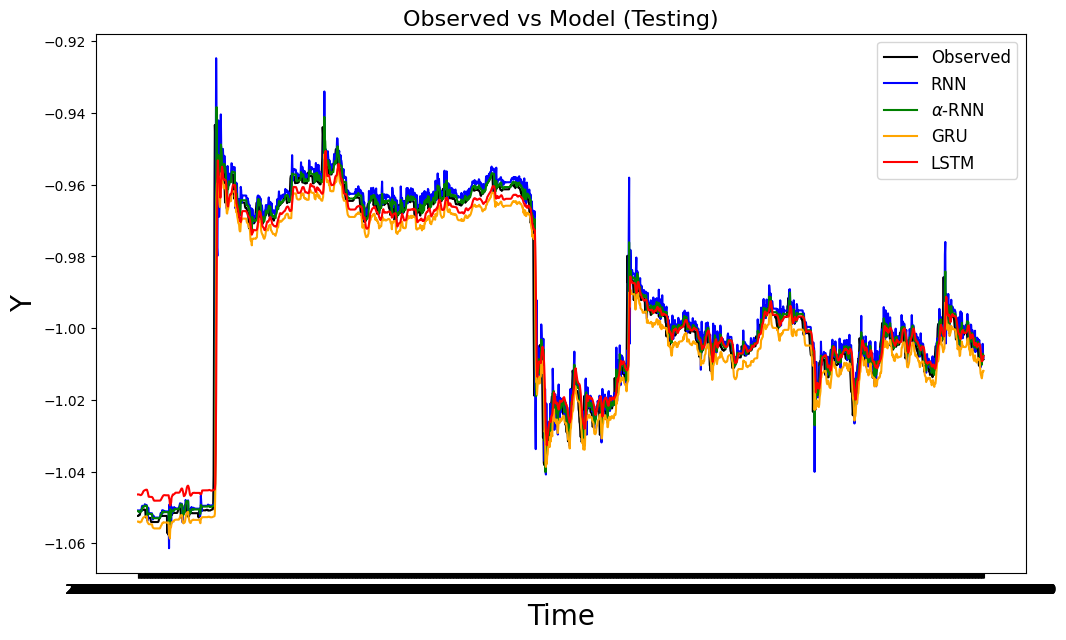

In [125]:
fig = plt.figure(figsize=(12,7))
upper = 2000
plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper], color="black", label="Observed")

for key in params.keys():
  print(key)
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'])
plt.legend(loc="best", fontsize=12)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.show()

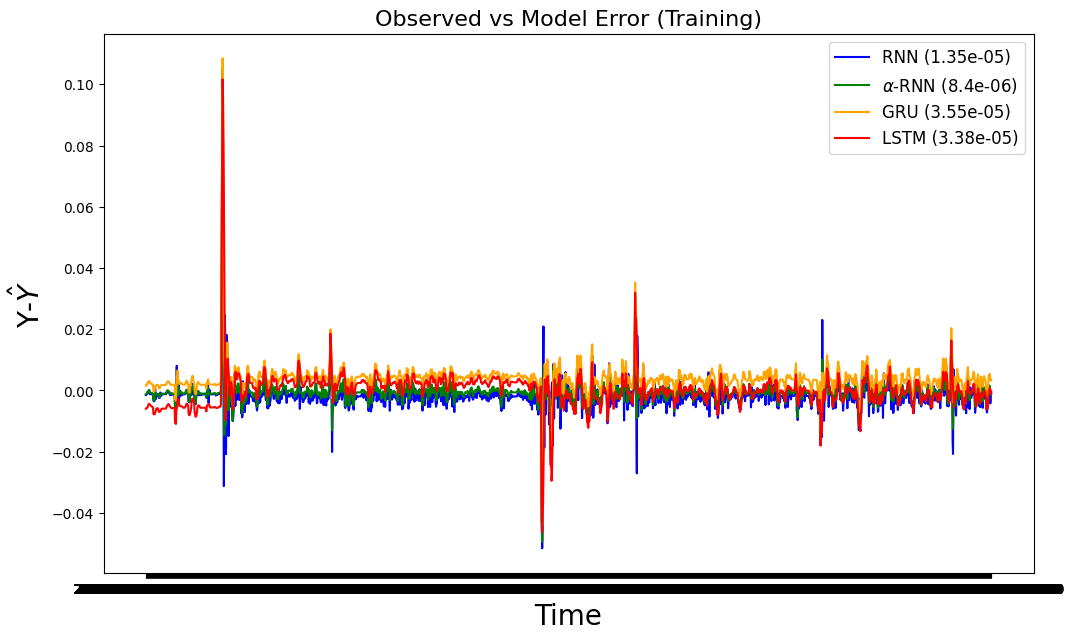

In [127]:
fig = plt.figure(figsize=(12,7))

for key in params.keys():
   plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper]-params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'] + " (" +  str(round(params[key]['MSE_test'],7)) +")")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()

In [ ]:
for key, value in params.items():
    if value['model'] != '':
        tf.keras.models.save_model(value['model'], f"{key}.hdf5", overwrite=True, save_format='h5')

In [ ]:
custom_objects = {
    'AlphaRNN': AlphaRNN,
    'AlphaRNNCell': AlphaRNNCell,
    'SimpleRNN_': SimpleRNN_,
    'AlphaRNN_': AlphaRNN_,
    'GRU_': GRU_,
    'LSTM_': LSTM_
}

for key, value in params.items():
    try:
        value['model'] = tf.keras.models.load_model(f"{key}.hdf5", custom_objects=custom_objects)
    except Exception as e:
        print(f"Error loading model for {key}: {str(e)}")
        value['model'] = value['function'](n_units=value['H'], l1_reg=value['l1_reg'])